In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
from glob import glob
import joblib

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [3]:
import pandas as pd

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla T4


In [5]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [13]:
config = AttrDict()

config.n_epoch = 1000
config.batch_size = 32
config.learning_rate = 1e-3
config.b1 = 0.5
config.b2 = 0.999

config.augmentation = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = [0.5], std = [0.5])
                                        ])
config.denormalize = lambda x: x*0.5 + 0.5
config.data_path = '/content/drive/MyDrive/Implement/data/SISR'
config.B200 = config.data_path + '/BSDS200/BSDS200' 
config.B100 = config.data_path + '/BSDS100/BSDS100/'
config.G100 = config.data_path + '/General100/General100/'

# preprocess data path
config.dataset_path = '/content/drive/MyDrive/Implement/SR'

## Dataset 구축 - LR & SR pair

In [7]:
img_list_b1 = glob(config.B100 + '/*')
img_list_b2 = glob(config.B200 + '/*')
img_list_g1 = glob(config.G100 + '/*')

img_list_b1.sort()
img_list_b2.sort()
img_list_g1.sort()

In [8]:
img_list_b2[:5]

['/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100075.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100080.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100098.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/103041.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/104022.png']

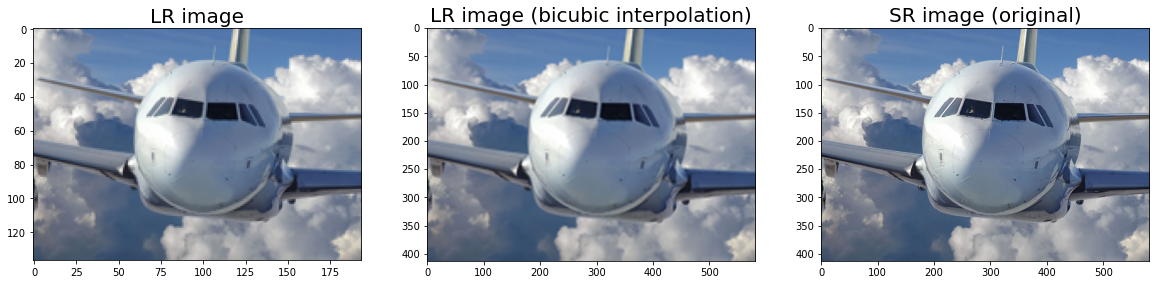

In [9]:
# img_sr = Image.open(img_list_b2[1])
img_sr = Image.open(img_list_g1[1])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

fig = plt.figure(figsize = (20, 60))
plt.subplot(131)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(132)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(133)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

# plt.suptitle('x3')
plt.show()

In [11]:
np_sr = np.array(img_sr)
np_lr = np.array(img_lr)
print(f"np_sr shape : {np_sr.shape}")
print(f"np_lr shape : {np_lr.shape}")

np_sr shape : (413, 582, 3)
np_lr shape : (137, 194, 3)


In [12]:
crop_sr = Image.fromarray(np_sr[150:300, 150:300][:])
crop_lr = Image.fromarray(np_lr[50:100, 50:100][:])

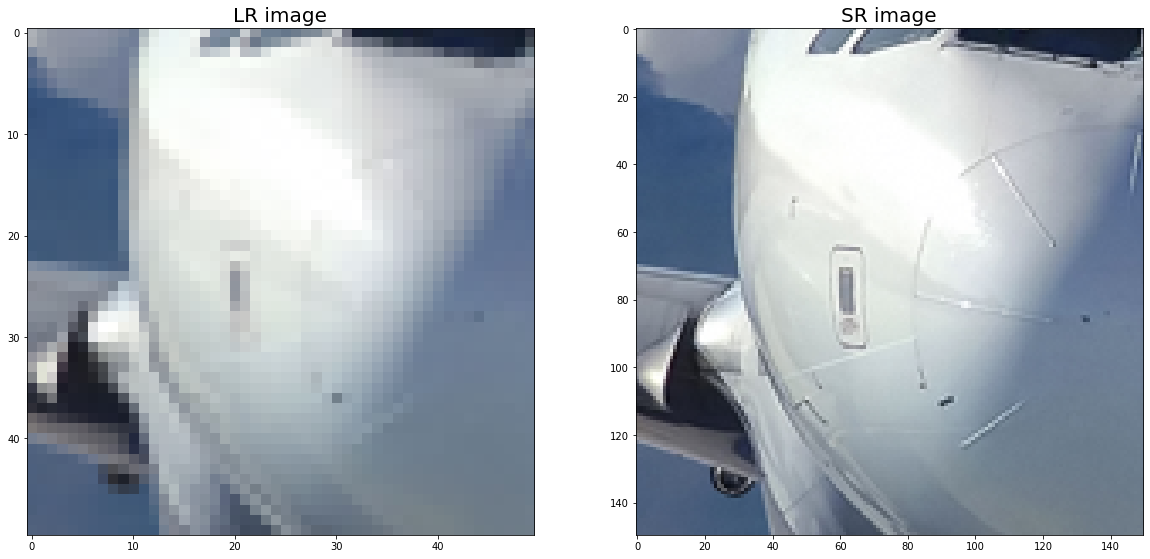

In [13]:
fig = plt.figure(figsize = (20, 40))
plt.subplot(121)
plt.title('LR image', fontsize = 20)
plt.imshow(crop_lr)

plt.subplot(122)
plt.title('SR image', fontsize = 20)
plt.imshow(crop_sr)

## Experiment

Augment:
1. Downscaling [1.0, 0.9, 0.8, 0.7, 0.6]
2. Rotation [0, 90, 180, 270]

▶ 5 x 4 = 20 배

In [15]:
def bname_extract(s):
    s = s.split('/')[-1]
    s = s.split('.')[0]
    return s

In [16]:
bname_extract(img_list_b1[0])

'101085'

In [25]:
downscale_list = [1.0, 0.9, 0.8, 0.7, 0.6]
rotation_list = [0, 90, 180, 270]

lr_mem = []
sr_mem = []
name_mem = []

# scaling factor = 3
# x2는 차이가 덜 뚜렷함
s_factor = 4
patch_size = 32 # lr 기준
lr_stride = 10

for img_path in tqdm(img_list_g1):
    img = Image.open(img_path)
    img_list = []

    # g1 name ex) 001
    # img_name = img_path[-7:-4]

    # b1 name
    img_name = bname_extract(img_path)

    # img_list = 20 augmentated image
    for ds in downscale_list:
        for theta in rotation_list:
            temp = img.resize((int(img.width * ds), int(img.height * ds)), resample = Image.BICUBIC)
            temp = temp.rotate(angle = theta)

            # scaling_factor remain 제거
            temp = temp.resize(((temp.width // s_factor) * s_factor, (temp.height // s_factor) * s_factor),
                                   resample = Image.BICUBIC)
            img_list.append(temp)
    
    for sr_image in img_list:
        lr_image = sr_image.resize((sr_image.width // s_factor, sr_image.height // s_factor), 
                                   resample = Image.BICUBIC)
        sr_np = np.array(sr_image)
        lr_np = np.array(lr_image)

        for y in range(0, lr_np.shape[0] - patch_size + 1, lr_stride):
            for x in range(0, lr_np.shape[1] - patch_size + 1, lr_stride):
                lr_patch = lr_np[y : y + patch_size, x : x + patch_size]
                sr_patch = sr_np[y * s_factor : (y + patch_size) * s_factor,
                                 x * s_factor : (x + patch_size) * s_factor]
                name_patch = {}
                name_patch['img_name'] = img_name
                name_patch['lr_x'] = x
                name_patch['lr_y'] = y
                name_patch['s_factor'] = s_factor

                lr_mem.append(lr_patch)
                sr_mem.append(sr_patch)
                name_mem.append(name_patch)


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


In [26]:
print(f"lr_mem shape: {len(lr_mem)}")
print(f"sr_mem shape: {len(sr_mem)}")

lr_mem shape: 76032
sr_mem shape: 76032


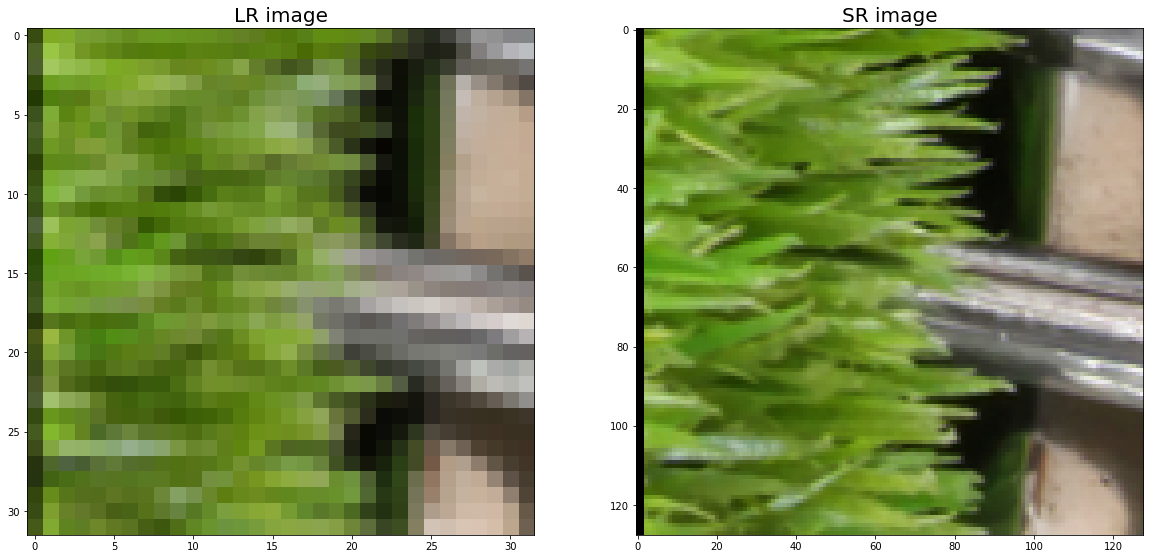

In [27]:
fig = plt.figure(figsize = (20, 40))

sr_sample = sr_mem[10000]
lr_sample = lr_mem[10000]

plt.subplot(121)
plt.title('LR image', fontsize = 20)
plt.imshow(Image.fromarray(lr_sample))

plt.subplot(122)
plt.title('SR image', fontsize = 20)
plt.imshow(Image.fromarray(sr_sample))

In [28]:
# patch 저장
joblib.dump(lr_mem, '/content/drive/MyDrive/Implement/SR/General100/4x/lr_mem.pkl')
joblib.dump(sr_mem, '/content/drive/MyDrive/Implement/SR/General100/4x/sr_mem.pkl')
joblib.dump(name_mem, '/content/drive/MyDrive/Implement/SR/General100/4x/name_mem.pkl')

['/content/drive/MyDrive/Implement/SR/General100/4x/name_mem.pkl']

In [10]:
class patch_dataset(Dataset):
    def __init__(self, name):
        # name: BSDS100, BSDS200, General100
        self.name = name
        # /content/drive/MyDrive/Implement/SR/BSDS100
        self.path = config.dataset_path

        self.data = joblib.load(self.path + '/' +  self.name + '/4x/lr_mem.pkl')
        self.target = joblib.load(self.path + '/' +  self.name + '/4x/sr_mem.pkl')
        self.info = joblib.load(self.path + '/' +  self.name + '/4x/name_mem.pkl')

        self.pp = config.augmentation

    def __getitem__(self, idx):
        # lr(input), sr(output), info(name dict)
        
        return self.pp(self.data[idx]), self.pp(self.target[idx]), self.info[idx]

    def __len__(self):
        return len(self.info)

In [14]:
train_loader = DataLoader(patch_dataset(name = 'General100'), batch_size = config.batch_size, shuffle = True, drop_last = True)
# test_loader = DataLoader(patch_dataset(name = 'BSDS100'), batch_size = config.batch_size, shuffle = True)

In [15]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 32, 32])

In [16]:
# 첫번째 단에서 BN X, PReLU & LeakyReLU 있으므로 따로 module로 구현
class conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=True, BN=True, act=None):
        super(conv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, bias = bias))
        if BN:
            layers.append(nn.BatchNorm2d(out_channels))
        if act is not None:
            layers.append(act)
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

class ResBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3, act = nn.PReLU(64)):
        super(ResBlock, self).__init__()
        layers = []
        layers.append(conv(channels, channels, kernel_size, stride = 1, padding = 1, bias = True, BN = True, act = act))
        layers.append(conv(channels, channels, kernel_size, stride = 1, padding = 1, bias = True, BN = True, act = None))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        res = self.layers(x)
        x = x + res
        return x
    
class G_Body(nn.Module):
    def __init__(self, B):
        super(G_Body, self).__init__()
        layers = []
        self.conv1 = conv(3, 64, 9, 1, 4, bias = True, BN = False, act = nn.PReLU(64))
        for _ in range(B):
            layers.append(ResBlock(64, 3, act = nn.PReLU(64)))
        self.body = nn.Sequential(*layers)
        self.conv2 = conv(64, 64, 3, 1, 1, bias = True, BN = True, act = None)
    
    def forward(self, x):
        res = self.conv1(x)
        out = self.body(res)
        out = self.conv2(out)
        out = out + res
        return out

class upsample(nn.Module):
    def __init__(self, channels, upscaling):
        super(upsample, self).__init__()
        layers = []
        layers.append(conv(channels, channels * upscaling ** 2, 3, 1, bias = True, BN = False, act = None))
        layers.append(nn.PixelShuffle(upscaling))
        layers.append(nn.PReLU(channels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

class Generator(nn.Module):
    def __init__(self, num_blocks = 16, upscaling = 4):
        super(Generator, self).__init__()
        self.body = G_Body(B = 16)
        upscaling_layers = [upsample(64, 2) for _ in range(2)]
        self.upscaling_layers = nn.Sequential(*upscaling_layers)
        self.conv = conv(64, 3, 9, 1, 4, bias = True, BN = False, act = nn.Tanh())

    def forward(self, x):
        x = self.body(x)
        x = self.upscaling_layers(x)
        x = self.conv(x)
        return x

class d_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, act = nn.LeakyReLU(inplace = True)):
        super(d_block, self).__init__()
        layers = []
        layers.append(conv(in_channels, out_channels, kernel_size, 1, 1, bias = True, BN = True, act = act))
        layers.append(conv(out_channels, out_channels, kernel_size, 2, 1, bias = True, BN = True, act = act))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

# 논문에서는 3 block => min patch_size = 16x16 => 4x upscaling이면 4x4이상 가능
class Discriminator(nn.Module):
    def __init__(self, c = 64, num_blocks = 3, patch_size = 64):
        super(Discriminator, self).__init__()
        self.act = nn.LeakyReLU(inplace = True)
        self.conv1 = conv(3, c, 3, 1, 1, True, False, self.act)
        self.conv2 = conv(64, c, 3, 2, 1, True, True, self.act)
        # body = [d_block(64, 128), d_block(128, 256), d_block(256, 512)]
        body = [d_block(c * (2 ** i), c * (2 ** (i+1)), 3, self.act) for i in range(num_blocks)]
        self.body = nn.Sequential(*body)
        # 64 // 2^4 = 4x4, 16 * (64 * 8)
        self.flat_size = ((patch_size // (2 ** (num_blocks + 1))) ** 2) * (c * (2 ** num_blocks))
        fc = [nn.Linear(self.flat_size, 1024), self.act, nn.Linear(1024, 1), nn.Sigmoid()]
        self.fc = nn.Sequential(*fc)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.body(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
        
class feature_extractor(nn.Module):
    def __init__(self):
        super(feature_extractor, self).__init__()
        self.model = models.vgg19(pretrained = True)
        self.num_layers = [0, 5, 10, 19, 28]

    def forward(self, x):
        fm_list = []
        for n, layer in enumerate(self.model.features):
            x = layer(x)
            if n in self.num_layers:
                fm_list.append(x)
        return fm_list
"""
128 x 128 patch 기준
0 shape torch.Size([5, 64, 128, 128])   x32
1 shape torch.Size([5, 128, 64, 64])    x16
2 shape torch.Size([5, 256, 32, 32])    x8
3 shape torch.Size([5, 512, 16, 16])    x4
4 shape torch.Size([5, 512, 8, 8])      x1
"""

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.feature_extractor = feature_extractor()
        self.feature_extractor.cuda()
        self.criterion = nn.MSELoss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

    def forward(self, x, y):
        x_fm, y_fm = self.feature_extractor(x), self.feature_extractor(y)
        loss = 0
        for i in range(5): # 0 ~ 4
            loss += self.weights[i] * self.criterion(x_fm[i], y_fm[i].detach())
        return loss

In [17]:
G = Generator(num_blocks = 16, upscaling = 4).cuda()
D = Discriminator(c = 64, num_blocks = 3, patch_size = 32 * 4).cuda()

criterionVGG = VGGLoss()
criterionMSE = nn.MSELoss()
criterionBCE = nn.BCELoss()

g_optimizer = torch.optim.Adam(G.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))
d_optimizer = torch.optim.Adam(D.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# pretrain with L2 loss
torch.autograd.set_detect_anomaly(True)
for epoch in range(100):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    G.train()
    train_loss = 0
    for i, (lr_images, targets, _) in enumerate(train_loader): 
        lr_images, targets = lr_images.to(device), targets.to(device)
        sr_images = G(lr_images)
        loss = criterionMSE(sr_images, targets)    
        train_loss += loss.item()
        
        g_optimizer.zero_grad()
        loss.backward()
        g_optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    G.eval()
    val_loss = 0
    for i, (lr_images, targets, _) in enumerate(test_loader):
        lr_images, targets = lr_images.to(device), targets.to(device)
        sr_images = G(lr_images)
        loss = criterionMSE(sr_images, targets)   
        val_loss += loss.item()

        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))


        


## Pretrain 결과

In [81]:
torch.save(G.state_dict(), '/content/drive/MyDrive/Implement/SRGAN/pretrain_G.pth')

In [18]:
G.load_state_dict(torch.load('/content/drive/MyDrive/Implement/SRGAN/pretrain_G.pth'))

<All keys matched successfully>

In [ ]:
G = G.to('cpu')
G.eval()

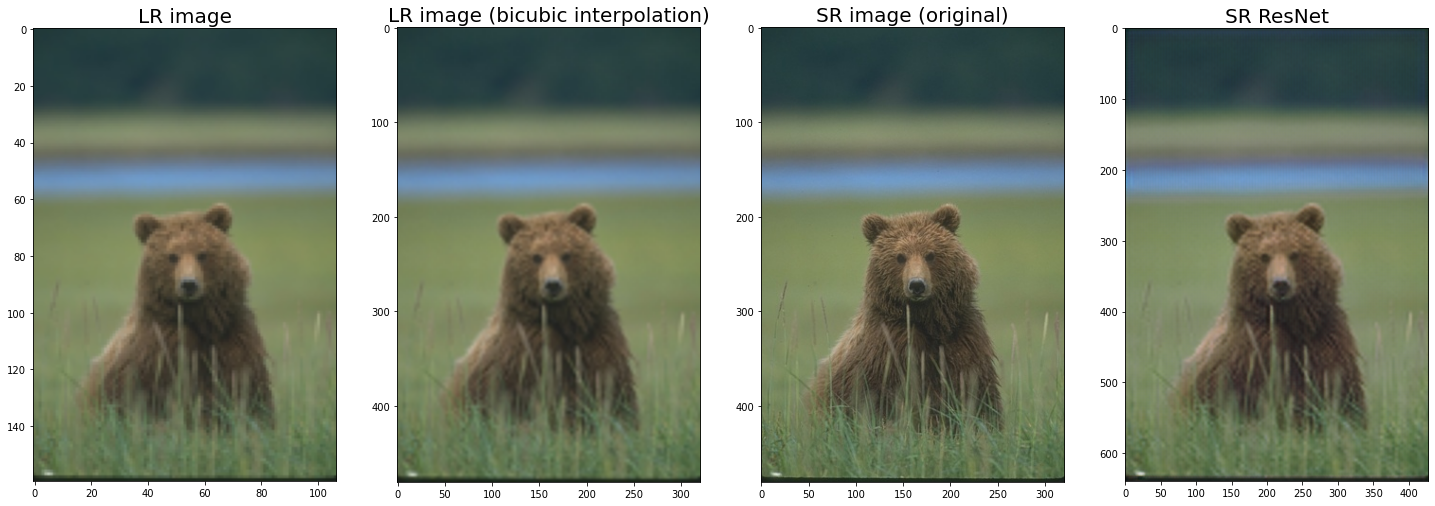

In [80]:

img_sr = Image.open(img_list_b2[1])
# img_sr = Image.open(img_list_b1[0])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

lr_numpy = np.array(img_lr)
lr_t = config.augmentation(lr_numpy)
output = G(lr_t.unsqueeze(0))
output = output.squeeze(0)
output = config.denormalize(output)
output = torchvision.transforms.ToPILImage()(output)

fig = plt.figure(figsize = (25, 100))
plt.subplot(141)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(142)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(143)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

plt.subplot(144)
plt.title('SR ResNet', fontsize = 20)
plt.imshow(output)
plt.show()

In [20]:
G = G.cuda()

In [ ]:
D.train()
G.train()

In [ ]:
for epoch in tqdm(range(config.n_epoch)):
    for i, (lr_images, targets, _) in enumerate(train_loader): 
        lr_images, targets = lr_images.to(device), targets.to(device)
        real_label = torch.ones((config.batch_size, 1)).cuda()
        fake_label = torch.zeros((config.batch_size , 1)).cuda()

        # Discriminator
        sr_images = G(lr_images)
        d_real_loss = criterionBCE(D(targets), real_label)
        d_fake_loss = criterionBCE(D(sr_images.detach()), fake_label)
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator
        sr_images = G(lr_images)
        fake_prob = D(sr_images)

        loss_adv = 1e-3 * criterionBCE(fake_prob, real_label)
        loss_content = criterionVGG(sr_images, targets)

        g_loss = loss_adv + loss_content

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) == len(train_loader):
            print("Epoch [{}/{}]  Discriminator loss: {:.4f} Generator loss: {:.4f}".format(
                epoch+1, config.n_epoch, d_loss.item(), g_loss.item()))
        
        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
G = G.to('cpu')
G.eval()

In [ ]:
img_sr = Image.open(img_list_b2[1])
# img_sr = Image.open(img_list_b1[0])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

lr_numpy = np.array(img_lr)
lr_t = config.augmentation(lr_numpy)
output = G(lr_t.unsqueeze(0))
output = output.squeeze(0)
output = config.denormalize(output)
output = torchvision.transforms.ToPILImage()(output)

fig = plt.figure(figsize = (25, 100))
plt.subplot(141)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(142)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(143)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

plt.subplot(144)
plt.title('SR ResNet', fontsize = 20)
plt.imshow(output)
plt.show()